In [1]:
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.metrics import *
from sklearn.svm import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
import sklearn
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.preprocess import *
from evaluation.evaluate import *
from evaluation.benchmark import *
data = preprocess(path='../data/raw/CD_PD.mat')

In [2]:
K.clear_session()

## Predict label PD diagnosis

In [3]:
def get_age_gender_data(data, mode='diagnosis'):
    #get shuffled data
    data_train, data_test = split_by_patient(data)
    
    #label PD
    y_test = data_test[mode].astype(np.float32)
    y_train = data_train[mode].astype(np.float32)
    
    age_train = data_train['age'].astype(np.float32)
    age_train = age_train.reshape(1, *age_train.shape).T
    gender_train = data_train['gender'].astype(np.float32)
    gender_train = gender_train.reshape(1, *gender_train.shape).T

    age_test = data_test['age'].astype(np.float32)
    age_test = age_test.reshape(1, *age_test.shape).T
    gender_test = data_test['gender'].astype(np.float32)
    gender_test = gender_test.reshape(1, *gender_test.shape).T
    
    #x
    x_train = np.concatenate((age_train,gender_train),axis=1)
    x_test = np.concatenate((age_test, gender_test), axis=1)
    
    return x_test, x_train, y_test, y_train

In [4]:
x_test, x_train, y_test, y_train = get_age_gender_data(data)
x_train.shape, x_test.shape, y_test.shape, y_train.shape

((156, 2), (40, 2), (40,), (156,))

# Dense1 (age + gender)

In [5]:
def get_nn_model(n_features):
    #optimizer
    adam = Adam(lr=1e-4)
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(n_features,)))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-5)
    
    model.compile(loss='binary_crossentropy', optimizer=adam, callbacks=[reduce_lr])
    model.build()
    return model
_ = get_nn_model(2).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [6]:
x_train[0]

array([64.,  1.], dtype=float32)

In [7]:
model_svc = SVC(C=1.0, kernel='sigmoid', degree=3, gamma='auto',probability=True)
model_svc.fit(x_train, y_train)
y_pred = model_svc.predict(x_test)
print(y_pred)
evaluate(y_test, y_pred, verbose=True)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
--------evaluation---------
accuracy: 0.65
recall: 0.0
precision: 0.0
f1 score: 0.0
---------------------------


/Users/daidew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/daidew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.65, 0.0, 0.0, 0.0)

# Performance Evaluation

We will run the model training & inference k times and evaluate the average performance 

/Users/daidew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/daidew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


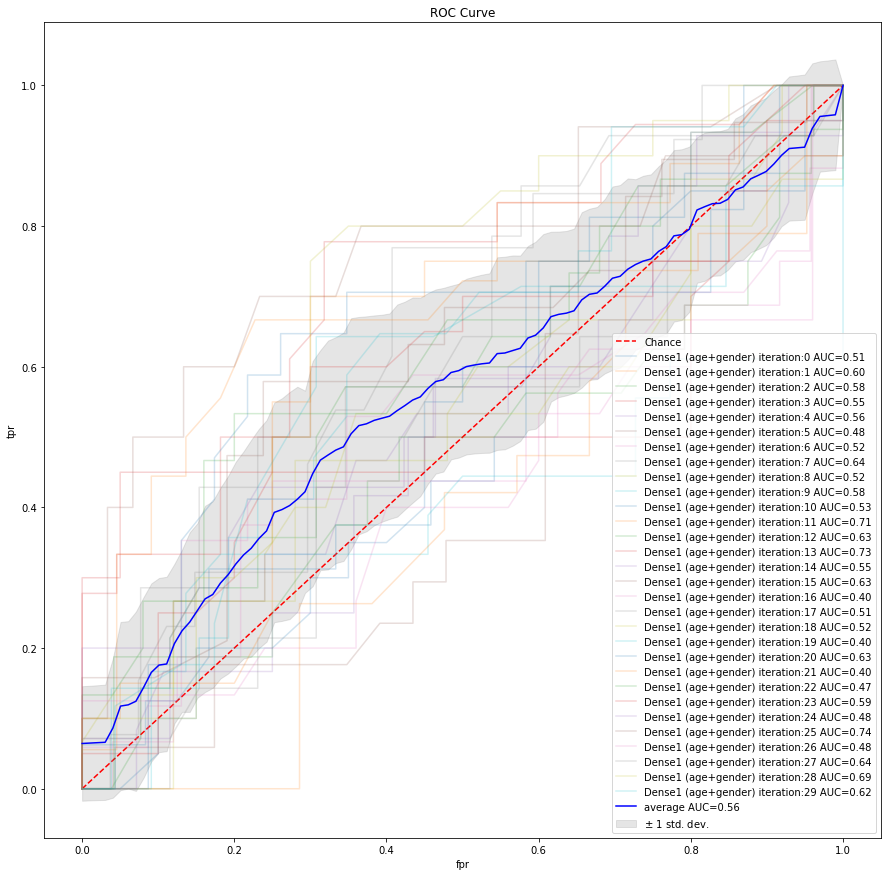

In [8]:
models1, plots1, results1 = run_benchmark(get_age_gender_data, get_nn_model, data, k=30, epochs=100, model_name='Dense1 (age+gender)')

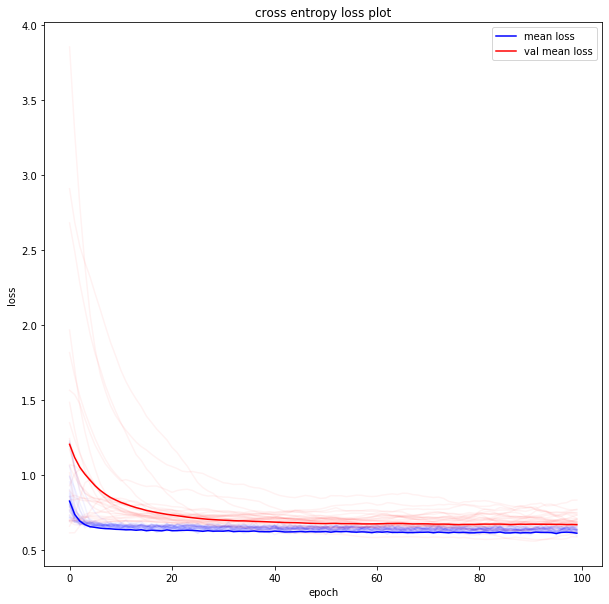

In [9]:
histories = results1['histories']
plt.figure(figsize=(10,10))
plt.title('cross entropy loss plot')
plt.xlabel('epoch')
plt.ylabel('loss')
mean_loss = None
val_mean_loss = None
for i, history in enumerate(histories[1:]):
    plt.plot(np.arange(len(history.history['loss'])),history.history['loss'],alpha=0.05,color='blue')
    plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'],alpha=0.05,color='red')
    if mean_loss is None:
        mean_loss = np.array(history.history['loss'])
        val_mean_loss = np.array(history.history['val_loss'])
    else:
        mean_loss += np.array(history.history['loss'])
        val_mean_loss += np.array(history.history['val_loss'])
mean_loss /= len(histories)
val_mean_loss /= len(histories)
plt.plot(np.arange(mean_loss.shape[0]), mean_loss,color='blue',label='mean loss')
plt.plot(np.arange(val_mean_loss.shape[0]), val_mean_loss,color='red',label='val mean loss')
plt.legend()
plt.show()

# Dense 2 (age + gender + Ed + Side + TMSE)

In [10]:
def get_all_non_temporal_data(data, mode='diagnosis'):
    #get shuffled data
    data_train, data_test = split_by_patient(data)
    
    #label PD
    y_test = data_test[mode].astype(np.float32)
    y_train = data_train[mode].astype(np.float32)
    
    features = ['age', 'gender', 'ed', 'side', 'TMSE']
    features_train, features_test = [], []
    for f in features:
        feature_train = data_train[f].astype(np.float32)
        feature_train = feature_train.reshape(1, *data_train.shape).T
        feature_test = data_test[f].astype(np.float32)
        feature_test = feature_test.reshape(1, *data_test.shape).T
        
        features_train.append(feature_train)
        features_test.append(feature_test)
    #x
    x_train = np.concatenate(features_train,axis=1)
    x_test = np.concatenate(features_test , axis=1)
    
    return x_test, x_train, y_test, y_train

#sanity check
x_test, x_train, y_test, y_train = get_all_non_temporal_data(data)
x_test[:3]

array([[45.,  1.,  4.,  1., 29.],
       [50.,  1.,  4.,  1., 28.],
       [60.,  1.,  1.,  1., 28.]], dtype=float32)

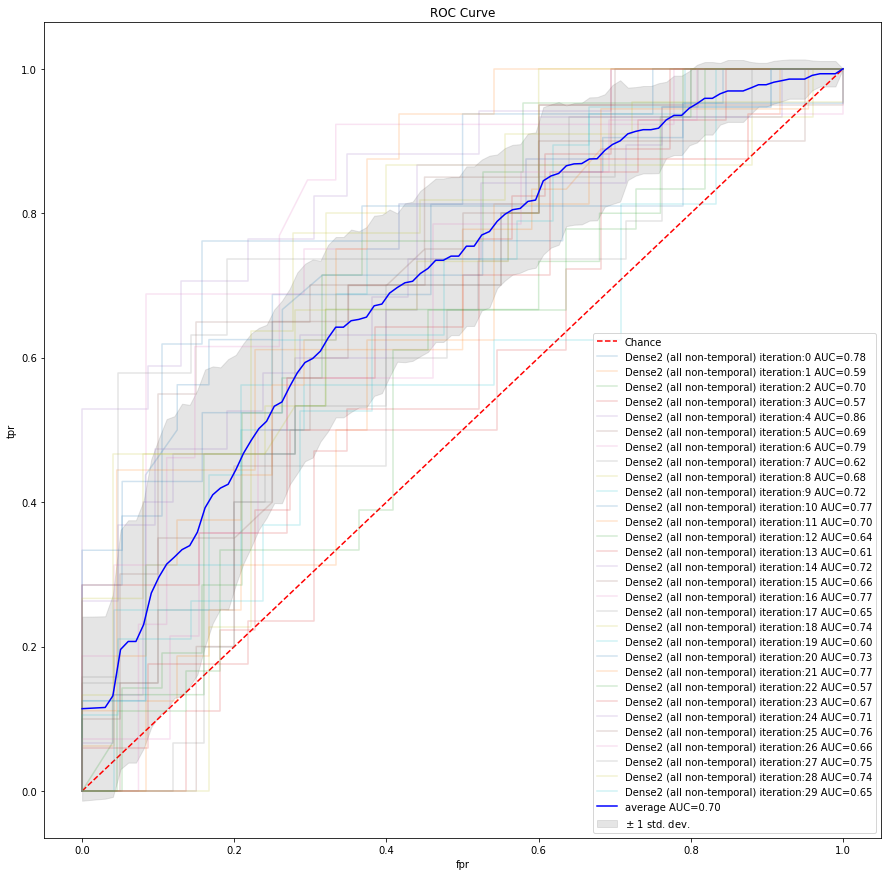

In [11]:
models2, plots2, results2 = run_benchmark(get_all_non_temporal_data, get_nn_model, data, k=30, epochs=100, \
                       model_name='Dense2 (all non-temporal)', verbose=0)


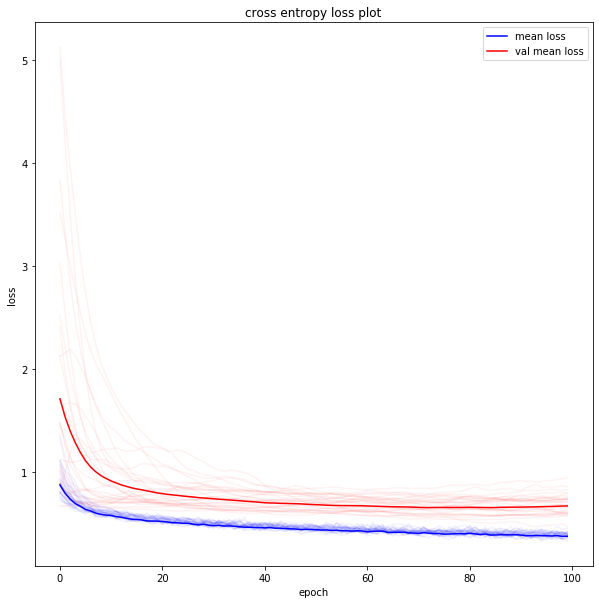

In [12]:
histories = results2['histories']
plt.figure(figsize=(10,10))
plt.title('cross entropy loss plot')
plt.xlabel('epoch')
plt.ylabel('loss')
mean_loss = None
val_mean_loss = None
for i, history in enumerate(histories[1:]):
    plt.plot(np.arange(len(history.history['loss'])),history.history['loss'],alpha=0.05,color='blue')
    plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'],alpha=0.05,color='red')
    if mean_loss is None:
        mean_loss = np.array(history.history['loss'])
        val_mean_loss = np.array(history.history['val_loss'])
    else:
        mean_loss += np.array(history.history['loss'])
        val_mean_loss += np.array(history.history['val_loss'])
mean_loss /= len(histories)
val_mean_loss /= len(histories)
plt.plot(np.arange(mean_loss.shape[0]), mean_loss,color='blue',label='mean loss')
plt.plot(np.arange(val_mean_loss.shape[0]), val_mean_loss,color='red',label='val mean loss')
plt.legend()
plt.show()

# Dense3 (prev. feature with total sum of pen pressure)

In [13]:
def get_data_3(data, mode='diagnosis'):
    #get shuffled data
    data_train, data_test = split_by_patient(data)
    
    #label PD
    y_test = data_test[mode].astype(np.float32)
    y_train = data_train[mode].astype(np.float32)
    
    features = ['age', 'gender', 'ed', 'side', 'TMSE']
    features_train, features_test = [], []
    for f in features:
        feature_train = data_train[f].astype(np.float32)
        feature_train = feature_train.reshape(1, *data_train.shape).T
        feature_test = data_test[f].astype(np.float32)
        feature_test = feature_test.reshape(1, *data_test.shape).T
        
        features_train.append(feature_train)
        features_test.append(feature_test)
    
    p_train = []
    p_test = []
    for i in range(data_train.shape[0]):
        p_train.append(np.sum(data_train['p'][i].astype(np.float32)))
    for i in range(data_test.shape[0]):
        p_test.append(np.sum(data_test['p'][i].astype(np.float32)))
        
    p_train = np.asarray(p_train)
    p_test = np.asarray(p_test)
    p_train = p_train.reshape(1, *p_train.shape).T
    p_test = p_test.reshape(1, *p_test.shape).T
    features_train.append(p_train)
    features_test.append(p_test)

    
    #x
    x_train = np.concatenate(features_train,axis=1)
    x_test = np.concatenate(features_test , axis=1)
    
    return x_test, x_train, y_test, y_train

#sanity check
x_test, x_train, y_test, y_train = get_data_3(data)
x_test[:3]

array([[ 78.      ,   0.      ,   0.      ,   1.      ,  29.      ,
        662.43176 ],
       [ 59.679348,   0.      ,   4.      ,   1.      ,  26.      ,
        893.4459  ],
       [ 65.      ,   1.      ,   3.      ,   1.      ,  30.      ,
        666.5281  ]], dtype=float32)

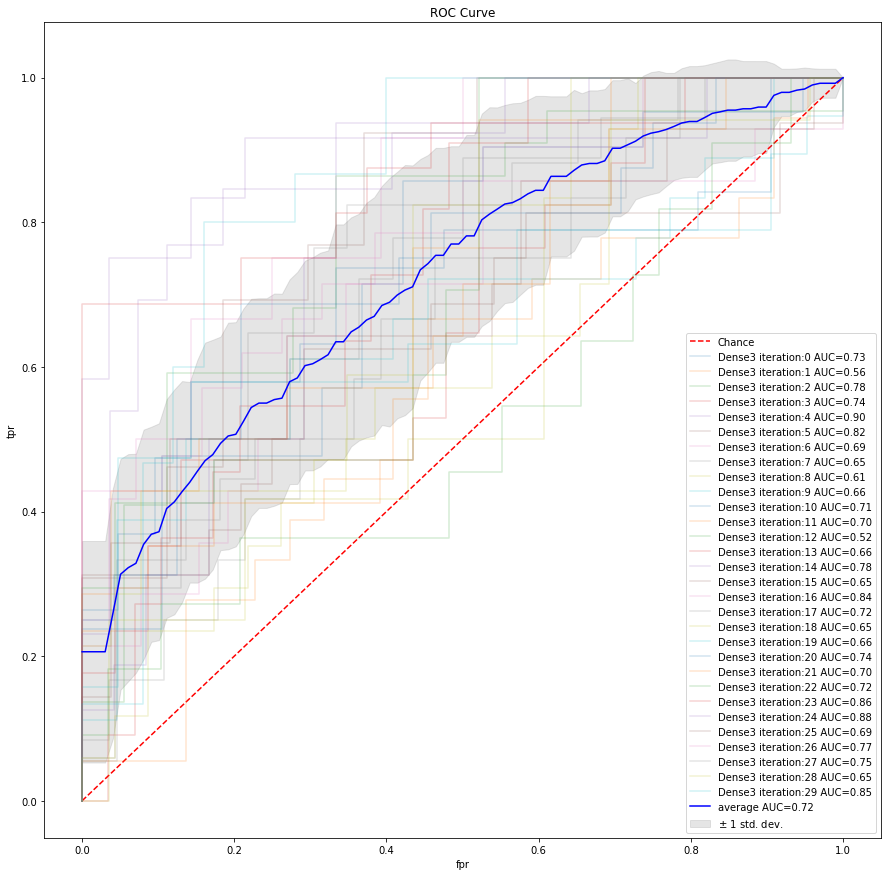

In [14]:
models3, plots3, results3 = run_benchmark(get_data_3, get_nn_model, data, k=30, epochs=200, \
                       model_name='Dense3', verbose=0)


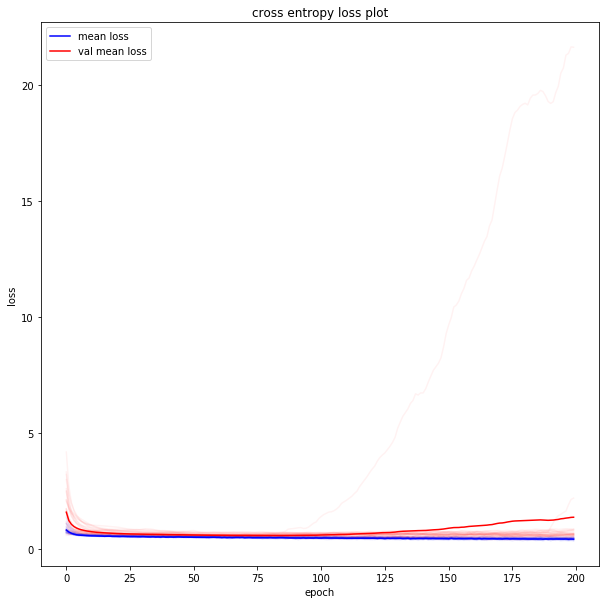

In [15]:
histories = results3['histories']
plt.figure(figsize=(10,10))
plt.title('cross entropy loss plot')
plt.xlabel('epoch')
plt.ylabel('loss')
mean_loss = None
val_mean_loss = None
for i, history in enumerate(histories[1:]):
    plt.plot(np.arange(len(history.history['loss'])),history.history['loss'],alpha=0.05,color='blue')
    plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'],alpha=0.05,color='red')
    if mean_loss is None:
        mean_loss = np.array(history.history['loss'])
        val_mean_loss = np.array(history.history['val_loss'])
    else:
        mean_loss += np.array(history.history['loss'])
        val_mean_loss += np.array(history.history['val_loss'])
mean_loss /= len(histories)
val_mean_loss /= len(histories)
plt.plot(np.arange(mean_loss.shape[0]), mean_loss,color='blue',label='mean loss')
plt.plot(np.arange(val_mean_loss.shape[0]), val_mean_loss,color='red',label='val mean loss')
plt.legend()
plt.show()

# Summary ROC Curve

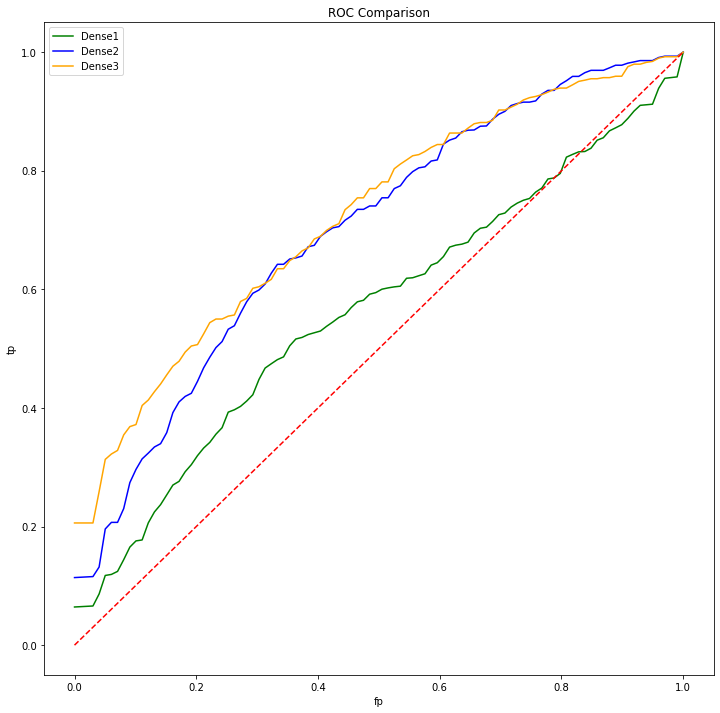

In [16]:
plt.figure(figsize=(12,12))
plt.plot(np.linspace(0,1,100), plots1['mean_tp'],label='Dense1', color='green')
plt.plot(np.linspace(0,1,100), plots2['mean_tp'],label='Dense2', color='blue')
plt.plot(np.linspace(0,1,100), plots3['mean_tp'],label='Dense3', color='orange')
plt.title('ROC Comparison')
plt.xlabel('fp')
plt.ylabel('tp')
plt.legend()
plt.plot([0, 1], [0, 1], color='red', label='Chance', linestyle='dashed')